In [2]:
import pandas as pd
import zipfile

#load zip file
zf = zipfile.ZipFile('data.zip') 
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))
print(df_wafers.head())

#load test data
df_wafers_test = pd.read_csv(zf.open('df_wafers_test.csv'))
print(df_wafers_test.head())

  WaferName  DieX  DieY  IsGoodDie  IsScratchDie
0    3b2e28     0    12      False         False
1    3b2e28     0    13       True         False
2    3b2e28     0    14      False         False
3    3b2e28     0    15       True         False
4    3b2e28     0    16       True         False
  WaferName  DieX  DieY  IsGoodDie
0    5a6ad6     0    12      False
1    5a6ad6     0    13       True
2    5a6ad6     0    14       True
3    5a6ad6     0    15       True
4    5a6ad6     0    16       True


In [3]:
wafer_groups = df_wafers.groupby('WaferName')
wafer_names = df_wafers['WaferName'].unique()

df_wafers_split = [wafer_groups.get_group(wafer) for wafer in wafer_names]

#show a histogram of the wafer sizes
import matplotlib.pyplot as plt
import numpy as np

print(df_wafers_split[0].shape)
print(df_wafers_split[0].head())

(1005, 5)
  WaferName  DieX  DieY  IsGoodDie  IsScratchDie
0    3b2e28     0    12      False         False
1    3b2e28     0    13       True         False
2    3b2e28     0    14      False         False
3    3b2e28     0    15       True         False
4    3b2e28     0    16       True         False


In [75]:
# take each wafer and convert it to a matrix with the same dimensions as the original image where each pixel is 0 or 1 depending on whether it is IsGoodDie or not

def wafer_to_matrix(wafer):
    # wafer_matrix = np.zeros((wafer['DieX'].max()+1, wafer['DieY'].max()+1))
    # create an array of the same size as the wafer matrix but with the data type int8 and -1 as the default value
    wafer_matrix = np.full((wafer['DieX'].max()+1, wafer['DieY'].max()+1), -1, dtype=np.int8)
    wafer_matrix = np.array(wafer_matrix, dtype=np.int8)
    die_x = wafer['DieX'].values 
    die_y = wafer['DieY'].values 
    is_good_die = wafer['IsGoodDie'].values
    wafer_matrix[die_x, die_y] = is_good_die
    return wafer_matrix





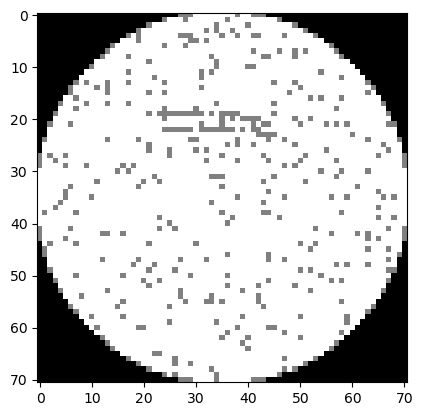

In [76]:
wafers_matrix = [wafer_to_matrix(wafer) for wafer in df_wafers_split]
plt.imshow(wafers_matrix[1000], cmap='gray')


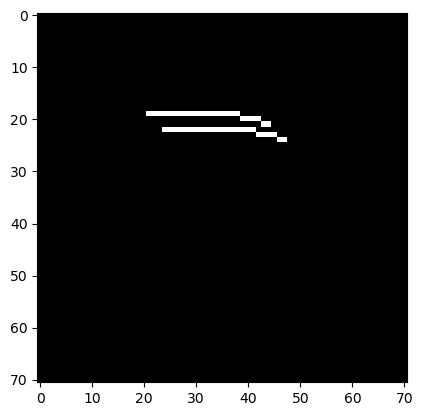

In [77]:
# y is the IsScratchDie for each die in the wafer if the (x,y) is in the wafer then the label is taken from the IsScratchDie column otherwise it is 0

def wafer_to_label_matrix(wafer):
    wafer_matrix = np.zeros((wafer['DieX'].max()+1, wafer['DieY'].max()+1))
    die_x = wafer['DieX'].values 
    die_y = wafer['DieY'].values 
    is_scratch_die = wafer['IsScratchDie'].values
    wafer_matrix[die_x, die_y] = is_scratch_die.astype(np.int8)
    return wafer_matrix

wafers_label_matrix = [wafer_to_label_matrix(wafer) for wafer in df_wafers_split]

plt.imshow(wafers_label_matrix[1000], cmap='gray')

In [78]:
y = wafers_label_matrix.copy()

#flatten the matrix to a vector and concatenate all the vectors into a single vector
y_flat = [y_i.flatten() for y_i in y]

y_flat = np.concatenate(y_flat)
y_flat = y_flat.astype(np.int8)

In [11]:
from tqdm import tqdm

def extract_rectangles(matrix_list, A):
    all_rectangles = []
    for matrix in tqdm(matrix_list):
        
        padded_matrix = np.pad(matrix, pad_width=((A // 2, A // 2), (A // 2, A // 2)), mode='constant', constant_values=0)
        rows, cols = matrix.shape
        shape = (rows, cols, A, A)
        strides = padded_matrix.strides + padded_matrix.strides
        window_view = np.lib.stride_tricks.as_strided(padded_matrix, shape=shape, strides=strides)
        flattened_windows = window_view.reshape((-1, A*A)).astype(np.int8)
        all_rectangles.extend(flattened_windows.tolist())
    return all_rectangles

rectangles = extract_rectangles(wafers_matrix, 7)

100%|██████████| 3920/3920 [02:29<00:00, 26.23it/s] 


In [12]:
import sys

print(sys.getsizeof(rectangles))
#save the rectangles to a file
import pickle

with open('rectangles_r7.pkl', 'wb') as f:
    pickle.dump(rectangles, f)




175662136


In [13]:
size = 5000000
X = rectangles.copy()[:size]
print(10)
y = y_flat.copy()[:size]
print(11)
y = np.array(y).astype(np.int8)
print(12)
X = np.array(X).astype(np.int8)
print(13)

#the data is very big so the calculations below take a long time, take a random sample of the data to speed up the calculations



10
11
12
13


In [15]:
import numpy as np
from collections import Counter

def under_sample(X, y):
    # assuming X is your feature matrix and y is your target variable
    # where y is 0.02 for the minority class and 0 for the majority class

    # get indices of minority and majority class samples
    minority_indices = np.where(y == 1)[0]
    majority_indices = np.where(y == 0)[0]

    # determine size of minority class
    minority_size = len(minority_indices)

    # randomly sample majority class
    random_majority_indices = np.random.choice(majority_indices, minority_size, replace=False)

    # concatenate minority class indices with randomly sampled majority class indices
    undersampled_indices = np.concatenate([minority_indices, random_majority_indices])

    # extract undersampled feature matrix and target variable
    X_undersampled = X[undersampled_indices, :]
    y_undersampled = y[undersampled_indices]

    return X_undersampled, y_undersampled

# check class distribution of undersampled data
X_undersampled, y_undersampled = under_sample(X, y)


Counter({1: 46556, 0: 46556})


In [16]:

X = X_undersampled
y = y_undersampled

print(Counter(y))

Counter({1: 46556, 0: 46556})


In [17]:


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
print(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(2)
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1)

print(3)
batch_size = 1000
for i in tqdm(range(0, len(X_train), batch_size)):
    rf.fit(X_train[i:i+batch_size], y_train[i:i+batch_size])

# predict the values of multiple dice for the test data with a progress bar
batch_size = 1000
y_pred = []
for i in tqdm(range(0, len(X_test), batch_size)):
    y_pred.extend(rf.predict(X_test[i:i+batch_size]))

accuracy = accuracy_score(y_test, y_pred)

1
2
3


100%|██████████| 19/19 [00:00<00:00, 51.85it/s]


0.8989421682865274
46556
0.5


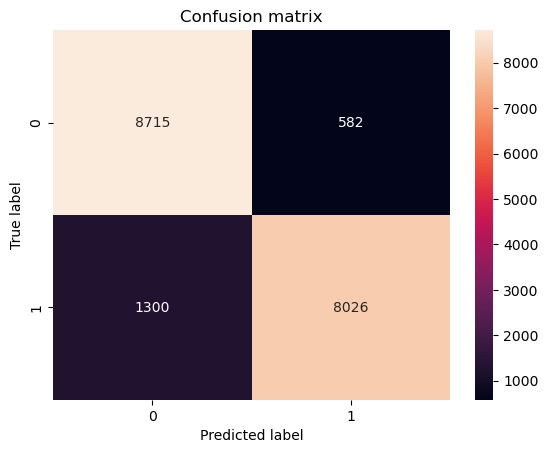

In [18]:
print(accuracy)
print(sum(y))
print(sum(y)/len(y))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


1


100%|██████████| 1000/1000 [00:24<00:00, 41.44it/s]


0.941702


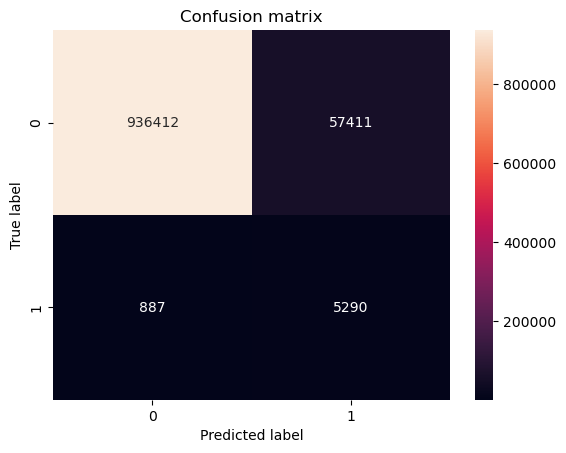

In [19]:
#for train i used the first 4000000 instances, now take the next 1000000 instances and predict them
test_X = rectangles[5000000:6000000].copy()
test_y = y_flat[5000000:6000000].copy()
print(1)

# predict the values of multiple dice for the test data with a progress bar
batch_size = 1000
y_pred = []
for i in tqdm(range(0, len(test_X), batch_size)):
    y_pred.extend(rf.predict(test_X[i:i+batch_size]))

accuracy = accuracy_score(test_y, y_pred)
print(accuracy)

cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [20]:
#lets try XGBoost now
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 1000
for i in tqdm(range(0, len(X_train), batch_size)):
    model.fit(X_train[i:i+batch_size], y_train[i:i+batch_size])

# predict the values of multiple dice for the test data with a progress bar
batch_size = 1000
y_pred = []
for i in tqdm(range(0, len(X_test), batch_size)):
    y_pred.extend(model.predict(X_test[i:i+batch_size]))
    
accuracy = accuracy_score(y_test, y_pred)


100%|██████████| 19/19 [00:00<00:00, 252.60it/s]


0.8986736830800622


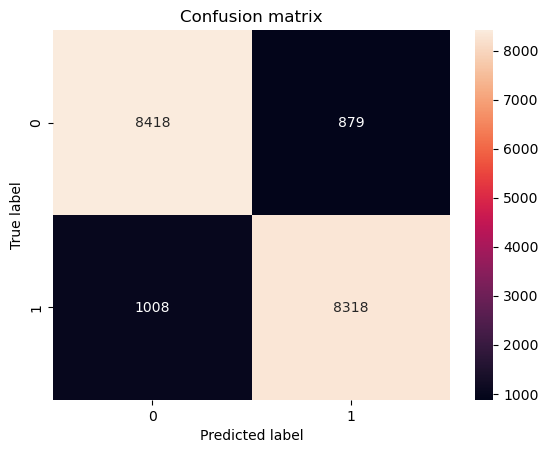

In [21]:
print(accuracy)

def plt_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plt_confusion_matrix(y_test, y_pred)


[LightGBM] [Info] Number of positive: 37230, number of negative: 37259
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 74489, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499805 -> initscore=-0.000779
[LightGBM] [Info] Start training from score -0.000779
0.9027546582183321


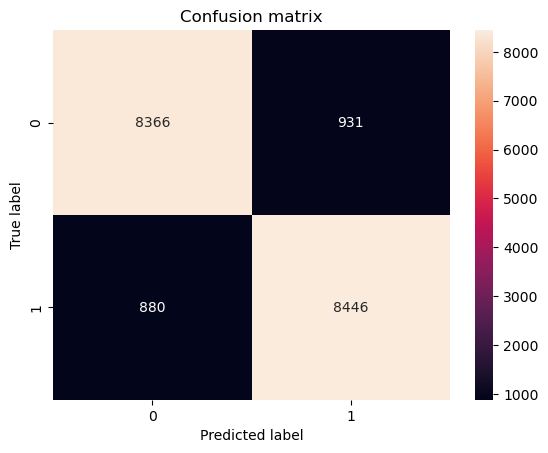

In [22]:
#lets try LightGBM now
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 15
params['min_data'] = 10
params['max_depth'] = 15

clf = lgb.train(params, d_train, 100)

y_pred=clf.predict(X_test)

y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
plt_confusion_matrix(y_test, y_pred)




In [24]:
X_train, X_test, y_train, y_test = train_test_split(rectangles, y_flat, test_size=0.1, random_state=42)

In [25]:
print(len(X_train))
print(len(X_test))
print(Counter(y_train))
print(Counter(y_test))

18820807
2091201
Counter({0: 18750014, 1: 70793})
Counter({0: 2083257, 1: 7944})


In [26]:
X_train = np.array(X_train).astype(np.int8)
y_train = np.array(y_train).astype(np.int8)

In [27]:
X_train, y_train = under_sample(X_train, y_train)

In [28]:
y_train = np.array(y_train).astype(int)
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)

In [29]:
print(Counter(y_train))
unique_labels = np.unique(y_train)
print(unique_labels)
print(y_train.shape)
print(X_train.shape)

Counter({1: 70793, 0: 70793})
[0 1]
(141586,)
(141586, 49)


[LightGBM] [Info] Number of positive: 70793, number of negative: 70793
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 141586, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.9310946197902545


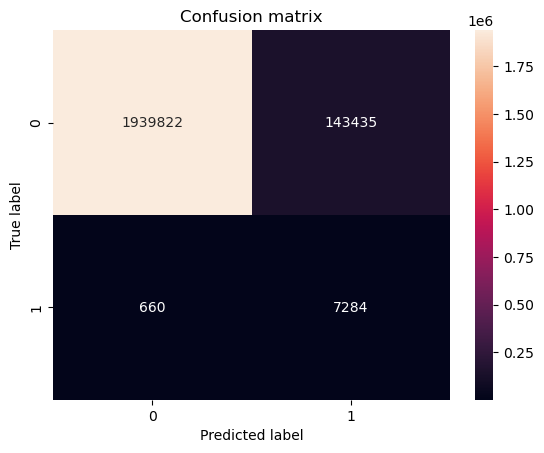

In [30]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

clf = lgb.train(params, d_train, 100)

y_pred=clf.predict(X_test)

y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
plt_confusion_matrix(y_test, y_pred)


In [31]:
wafer_groups_test = df_wafers_test.groupby('WaferName')
wafer_names_test = df_wafers_test['WaferName'].unique()

df_wafers_split_test = [wafer_groups_test.get_group(wafer) for wafer in wafer_names_test]

print(len(df_wafers_split_test))
print(df_wafers_split_test[0].shape)
print(df_wafers_split_test[0].head())

#take 3 examples

example = df_wafers_split_test[:3]

# we need to keep the length of the wafer for later
wafer_lengths = [len(wafer) for wafer in example]




439
(1005, 4)
  WaferName  DieX  DieY  IsGoodDie
0    5a6ad6     0    12      False
1    5a6ad6     0    13       True
2    5a6ad6     0    14       True
3    5a6ad6     0    15       True
4    5a6ad6     0    16       True


In [211]:
def wafer_to_matrix1(wafer):
    wafer_matrix = np.zeros((wafer['DieX'].max()+1, wafer['DieY'].max()+1))
    die_x = wafer['DieX'].values - 1
    die_y = wafer['DieY'].values - 1
    is_good_die = wafer['IsGoodDie'].values
    wafer_matrix[die_x, die_y] = is_good_die
    return wafer_matrix

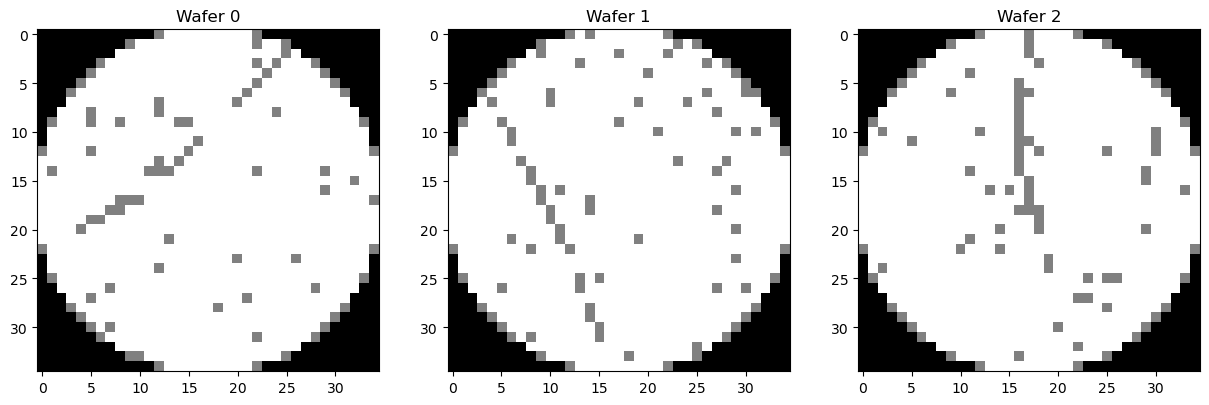

In [32]:
example_matrixs = [wafer_to_matrix(wafer) for wafer in example]

#plot the 3 examples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(example_matrixs[i],cmap='gray')
    ax.set_title('Wafer {}'.format(i))


In [33]:
#convert to rectangles
example_rectangles = extract_rectangles(example_matrixs,7)

#predict the labels
example_predictions = clf.predict(example_rectangles)

example_predictions [example_predictions>0.5] = 1
example_predictions [example_predictions<=0.5] = 0

print(example_predictions.shape)

#reshape the predictions
example_predictions = example_predictions.reshape(3,35,35)


100%|██████████| 3/3 [00:00<00:00, 75.53it/s]

(3675,)


In [65]:
def trim_edges(predictions,origin):

    trimmed_predictions =  predictions.copy()

    for i in range(len(predictions)):
        dim = predictions[i].shape
        # dim is (n,n) create array of (x,y) coordinates of the n*n grid
        coords = np.array(np.meshgrid(range(dim[0]), range(dim[1]))).T.reshape(-1,2)
        for coord in coords:
            # if the example[i] has (DieX, DieY) coordinates equal to the coord then keep the prediction else set it to -1
            if not any((origin[i]['DieX'] == coord[0]) & (origin[i]['DieY'] == coord[1])):
                trimmed_predictions[i][coord[0]][coord[1]] = -1


    return trimmed_predictions

trimmed_predictions = trim_edges(example_predictions,example)

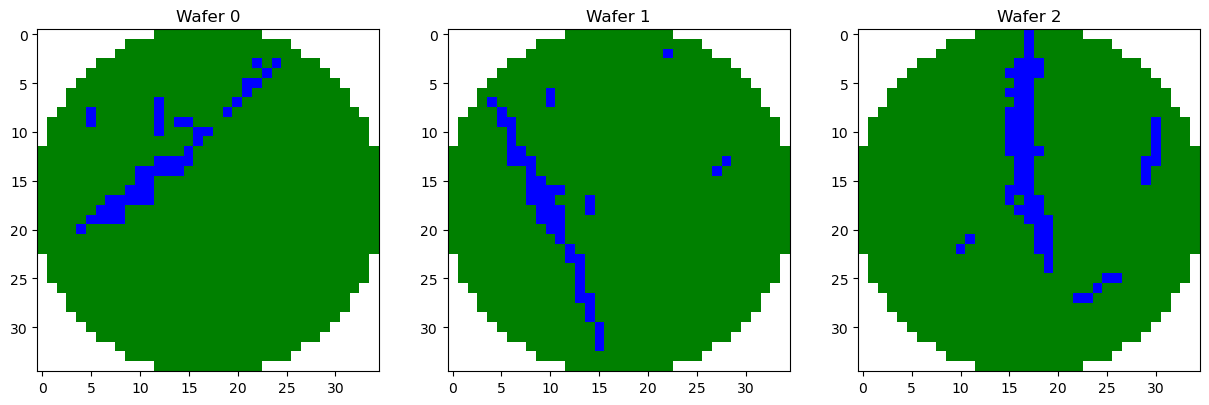

In [72]:
from matplotlib.colors import ListedColormap

color_map = ListedColormap(['white', 'green', 'blue'])


#plot the predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(trimmed_predictions[i],cmap=color_map)
    ax.set_title('Wafer {}'.format(i))


In [73]:
only_predictions = trimmed_predictions.copy()[trimmed_predictions != -1]
print(only_predictions.shape)

(3015,)


In [74]:
#now lets do this process for all the wafers in the test set
test_matrixs = [wafer_to_matrix(wafer) for wafer in df_wafers_split_test]

test_rectangles = extract_rectangles(test_matrixs,7)

test_predictions = clf.predict(test_rectangles)

test_predictions [test_predictions>0.5] = 1
test_predictions [test_predictions<=0.5] = 0




100%|██████████| 439/439 [00:07<00:00, 60.87it/s] 


In [59]:
print(len(df_wafers_test))

1860063


In [60]:
def remove_non_die_predictions(predictions,origin):
    #if at test_rectangles[i][24] (the center of the rectangle) the val is -1 then remove the prediction
    trimmed_predictions =  []
    for i in range(len(predictions)):
        if origin[i][24] != -1:
            trimmed_predictions.append(predictions[i])
    return trimmed_predictions

trimmed_predictions = remove_non_die_predictions(test_predictions,test_rectangles)
print(len(trimmed_predictions))
           


1860063


In [64]:
print(Counter(trimmed_predictions))
print(sum(trimmed_predictions)/len(trimmed_predictions)*100)

Counter({0.0: 1701449, 1.0: 158614})
8.527345579155114
